In [1]:
import numpy as np
from matplotlib import pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
from path_guiding import SurfaceInteraction, DiffuseShader, GlossyTransmissiveDielectricShader
from path_guiding import VMFMixture2, VMFFitIncremental2, VMFMixture8
import path_guiding

In [3]:
np.sqrt(284413745)

16864.570703104186

In [3]:
%matplotlib notebook

In [4]:
si = SurfaceInteraction([0., 1., 0.], [0., 1., 0.])

In [5]:
t = np.linspace(0., 2.*np.pi, 360)

In [6]:
cs = np.cos(t)
sn = np.sin(t)

In [7]:
incidents = np.vstack([cs,sn,np.zeros_like(cs)]).T

In [8]:
def make_sphere_grid():
    # https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/
    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2*np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)

    # The Cartesian coordinates of the unit sphere
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return x, y, z

def plot_vmf_pdf(ax, vmfm):
    x, y, z = make_sphere_grid()
    pts = np.vstack((x.ravel(),y.ravel(),z.ravel())).T
    fcolors = vmfm.pdf(pts).reshape(x.shape)
    fcolors /= fcolors.max()
    
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=matplotlib.cm.coolwarm(fcolors), shade=False)
    return fcolors

def plot_bsdf(ax, bsdf, wi, si):
    # https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/
    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2*np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)

    # The Cartesian coordinates of the unit sphere
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    pts = np.vstack((x.ravel(),y.ravel(),z.ravel())).T
    
    values = np.asarray([bsdf.Evaluate(wi, si, wo) for wo in pts])[:,0]
    values = values.reshape(x.shape)
    values /= values.max()
    #ax.scatter(x, y, z, c = values, s = 8., marker='o', cmap = matplotlib.cm.coolwarm, vmin=0., vmax=1.)
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=matplotlib.cm.coolwarm(values), shade=False)

In [9]:
def take_samples(shd, incident, si, n):
    return np.fromiter(
        (shd.Sample(incident, si) for _ in range(n)),
        dtype = [('w','f8',3), ('f','f8',3), ('p', 'f8'), ('delta', np.bool)])

In [10]:
def filter_out_of_plane(samples):
    mask = np.abs(samples['w'][:,2]) < (np.pi/180.*10.)
    return samples[mask]

-5.332338703922801e-08 5.55772085020223e-08
-3.458476488795414e-06 2.6782497757739097e-06
[0.00477622 0.02063529 0.0100845  0.00564841 0.00968665 0.01216258
 0.01294302 0.00396795 0.         0.         0.         0.
 0.         0.         0.         0.        ]


<IPython.core.display.Javascript object>


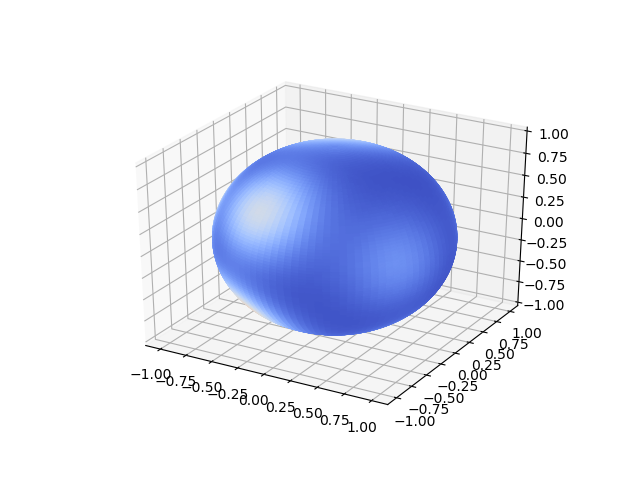

In [11]:
m2 = VMFMixture2()
m2.weights = [1., 0.]
m2.concentrations = [ 1., 1.]
m8 = VMFMixture8()
m8.concentrations = 10. * np.ones(8)
m16 = path_guiding.product(m2,m8)
x, y, z = make_sphere_grid()
pts = np.vstack((x.ravel(),y.ravel(),z.ravel())).T
m2_vals = m2.pdf(pts)
m8_vals = m8.pdf(pts)
m16_vals = m16.pdf(pts)
m16_expected = m2_vals*m8_vals
err = m16_vals - m16_expected
err = err.reshape(x.shape)
m16_expected = m16_expected.reshape(x.shape)
m16_vals = m16_vals.reshape(x.shape)
print (err.min(), err.max())
rel_err = err / m16_expected
print (rel_err.min(), rel_err.max())
print (m16.weights)

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

data = m16_vals

data = data/data.max()
surf = ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=matplotlib.cm.coolwarm(data), shade=False)

# m = matplotlib.cm.ScalarMappable(cmap=surf.cmap, norm=surf.norm)
# m.set_array(data)
# fig.colorbar(m)

In [12]:
shd = GlossyTransmissiveDielectricShader(1.5, 3.)
shd.InitializeLobes()

<IPython.core.display.Javascript object>


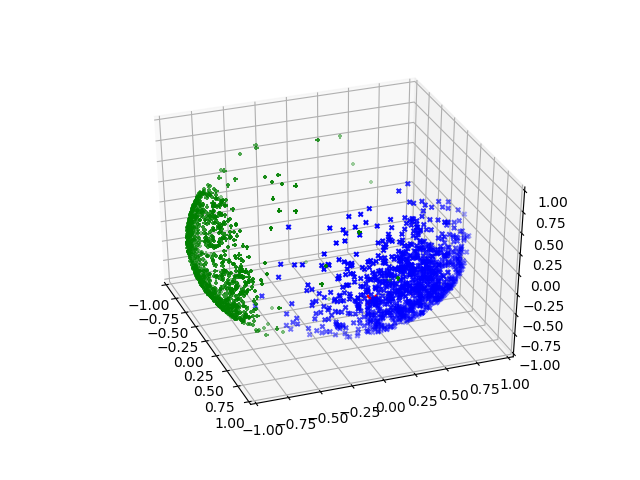

interactive(children=(IntSlider(value=90, description='wi_idx', max=179, min=1), IntSlider(value=90, descripti…

In [13]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')

@widgets.interact()
def interactive_plot(wi_idx = (1, 179, 1), shd_normal_phi = (1, 179, 1)):
    ax.clear()
    
    shd_normal_phi = np.pi/180.*shd_normal_phi
    si = SurfaceInteraction([0., 1., 0.], [np.cos(shd_normal_phi), np.sin(shd_normal_phi), 0.])
    
    samples = take_samples(shd, incidents[wi_idx], si, 1000)
    xs = samples['w'].astype(np.float32)
    ws = (samples['f'][:,0] / samples['p']).astype(np.float32)
    ax.scatter(*(xs*1.1).T, c='g', s = 10., marker='+')
    
    vmfm = shd.ComputeLobes(incidents[wi_idx], si)
    
    ax.scatter(*(vmfm.means*1.05).T, marker='x', c='r', s = 50., lw=2.)
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
    ax.set_zlim(-1.,1.)
    vmfm_smpl = vmfm.sample(1000)
    ax.scatter(*vmfm_smpl.T, c='b', marker='x', s= 10.)
    pyplot.show()

<IPython.core.display.Javascript object>


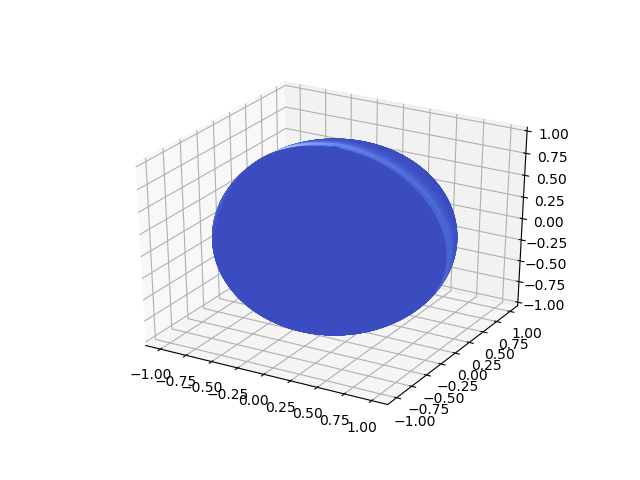

In [14]:
shd = GlossyTransmissiveDielectricShader(1.33, 8.)
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
plot_bsdf(ax, shd, incidents[5], si)

<IPython.core.display.Javascript object>


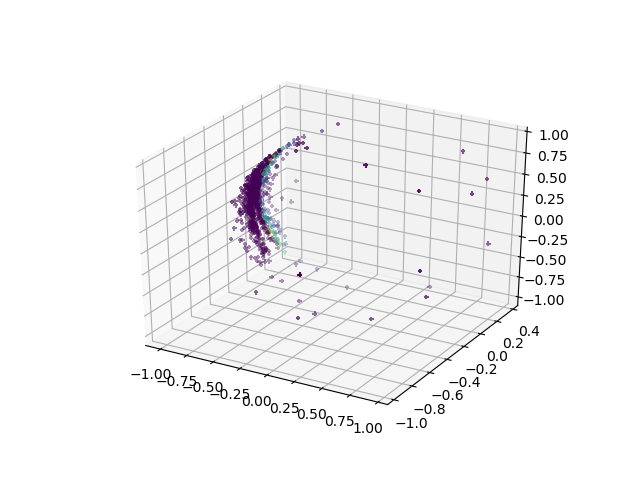

In [15]:
samples = (take_samples(shd, incidents[5], si, 1000))

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*samples['w'].T, c = samples['f'][:,0], s = 10., marker='+')

In [16]:
@widgets.interact()
def interactive_plot(wi_idx = (1, 179, 1), alpha = (0.1, 5., 0.1), shd_normal_phi = (1, 179, 1)):
    shd_normal_phi = np.pi/180.*shd_normal_phi
    si = SurfaceInteraction([0., 1., 0.], [np.cos(shd_normal_phi), np.sin(shd_normal_phi), 0.])
    shd = GlossyTransmissiveDielectricShader(1.2, alpha)
    samples = (take_samples(shd, incidents[wi_idx], si, 1000))
    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='polar')
    f = np.log10(samples['f'][:,0])
    rmax = np.amax(f)
    ax.plot([t[wi_idx]+np.pi, t[wi_idx]], [rmax, rmax], color='k', lw=2.)
    ax.plot([shd_normal_phi+np.pi, shd_normal_phi], [rmax, rmax], color='g', lw=2.)
    c = ax.scatter(np.arctan2(samples['w'][:,1],samples['w'][:,0]), f, s = 0.5)

interactive(children=(IntSlider(value=90, description='wi_idx', max=179, min=1), FloatSlider(value=2.500000000…

In [17]:
wi_idx = 10
shd = GlossyTransmissiveDielectricShader(1.33, 3.)
samples = take_samples(shd, incidents[wi_idx], si, 10000)
xs = samples['w'].astype(np.float32)
ws = (samples['f'][:,0] / samples['p']).astype(np.float32)

In [18]:
prior_nu = 1.
prior_alpha = 1.
prior_tau = 1.
prior_mode = VMFMixture2()
prior_mode.concentrations = [1.,1.]

vmfm = VMFMixture2()
for i in range(10):
    incremental = VMFFitIncremental2(
        prior_nu = prior_nu, 
        prior_alpha = prior_alpha, 
        prior_tau = prior_tau,
        prior_mode = prior_mode,
        maximization_step_every = 100)
    incremental.fit(vmfm, xs[i*1000:(i+1)*1000,:], ws[i*1000:(i+1)*1000])
    mu = vmfm.means
    mu[:,2] = 0.
    mu /= np.linalg.norm(mu, axis=1)[:,np.newaxis]
    vmfm.means = mu
    #prior_mode = vmfm

<IPython.core.display.Javascript object>


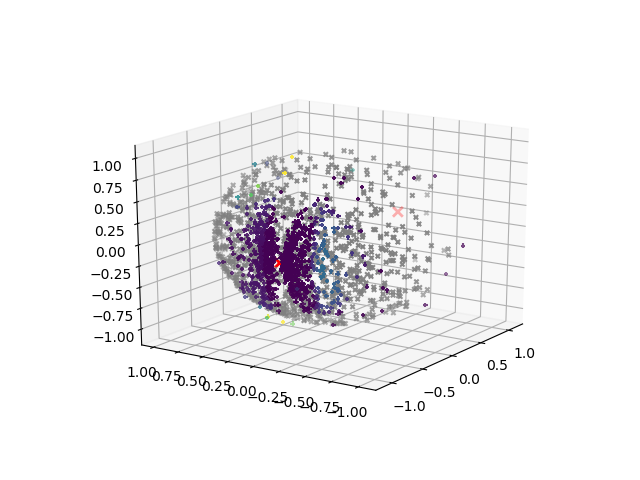

In [19]:
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*(vmfm.means*1.1).T, marker='x', c='r', s = 50., lw=2.)
ax.scatter(*(xs[:1000]*1.1).T, c=ws[:1000], s = 10., marker='+')
vmfm_smpl = vmfm.sample(1000)
ax.scatter(*vmfm_smpl.T, c='gray', marker='x', s= 10.)
pyplot.show()